# Aprendizaje, Generalización y Sobreajuste
## Validación cruzada
### Grupo de Meteorología de Santander
### 22 Nov 2018

# 1 Introducción

## Modelos de aprendizaje

Para que un problema sea adecuado para su resolución mediante técnicas de aprendizaje automático la condición fundamental es la existencia de datos para alimentar (entrenar) el algoritmo de aprendizaje.

De esta forma, a partir de un conjunto de datos de entrenamiento que se considera representativo de la distribución que se quiere modelar, nuestro modelo de aprendizaje viene dado por:

* El **algoritmo usado** para aprender el patrón y 
* La familia de **funciones** 
* Los **datos** que utilicemos para aproximar el patrón a aprender. 

De este modo, el proceso de aprendizaje dependerá de estos tres elementos, los cuales establecerán nuestras limitaciones e incertidumbres a la hora tanto de aprender el patrón como de realizar predicciones con el patrón aprendido.

## Generalización y sobreajuste

Recordemos que el objetivo principal del modelo aprendido es que tenga **la capacidad de generalizar**, es decir, la capacidad de funcionar bien para nuevos datos que no forman parte de la muestra de entrenamiento (por ejemplo, una muestra de datos de test). En caso contario, diremos que el modelo está **sobreajustado a la muestra de entrenamiento**. 

**La introducción de grados de libertad en la familia de funciones consideradas en el aprendizaje suele dar lugar a modelos sobreajustados**, por lo que suele ser conveniente partir de los modelos más simples e ir introduciendo grados de libertad progresivamente si fuera necesario.



En esta práctica utilizaremos...

* modelo: Regresion lineal
* Dataset: Auto (paquete ISLR)
* Validación: error medio absoluto (MAE) y error cuadrático medio (MSE)
* Librerías de R:

In [1]:
library(ISLR)
library(caret)

Loading required package: lattice
Loading required package: ggplot2


# 2 Carga y transformación de datos

El dataset Auto (paquete `ISLR`) contiene información sobre las características de 392 vehículos. Puede verse una descripción detallada del conjunto de datos mediante: `help("Auto", package = "ISLR")`

In [2]:
data(Auto)
str(Auto)

'data.frame':	392 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : num  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  3504 3693 3436 3433 3449 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : num  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : num  1 1 1 1 1 1 1 1 1 1 ...
 $ name        : Factor w/ 304 levels "amc ambassador brougham",..: 49 36 231 14 161 141 54 223 241 2 ...


In [3]:
# Conversión de libras a Kg
Auto$weight <- Auto$weight * 0.453592

Comenzamos con un análisis preliminar de nuestros datos:

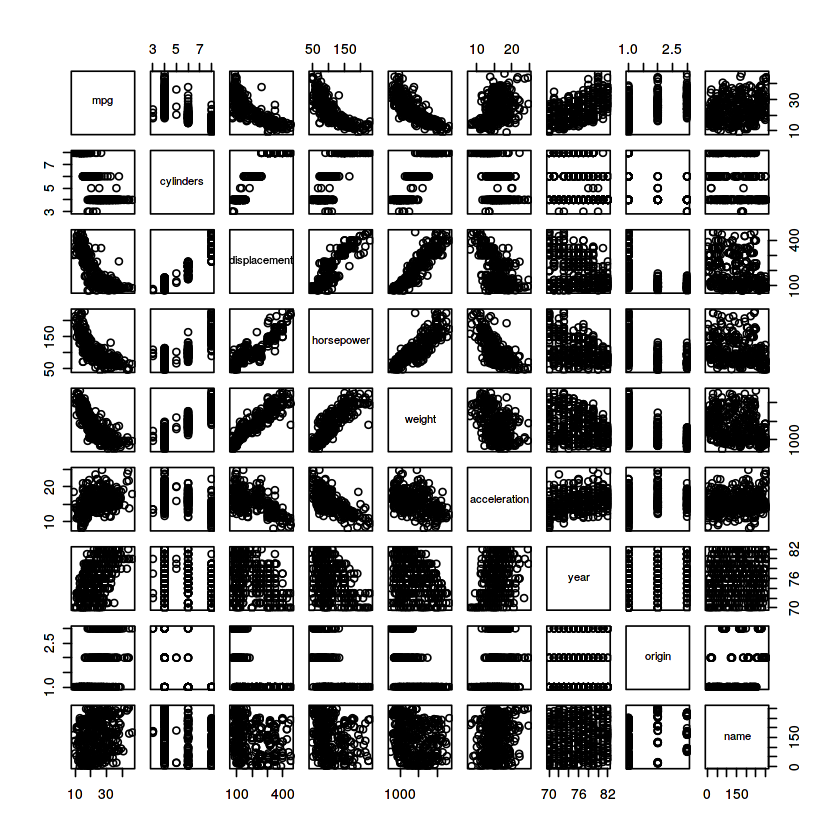

In [4]:
pairs(Auto)

En este ejemplo solo nos interesa la relación entre el peso (weight) y la potencia (horsepower).


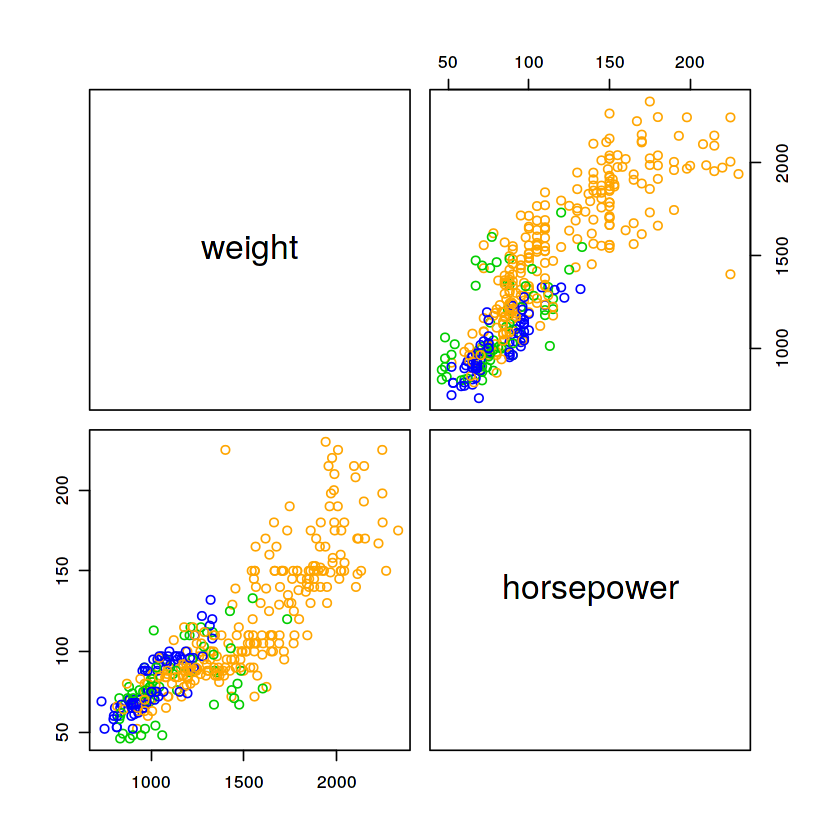

In [5]:
pairs(weight ~ horsepower, data = Auto, col = c("orange", "green3", "blue")[unclass(Auto$origin)])

#### Supuesto:

Imaginemos que una empresa X nos proporciona únicamente los registros o datos europeos para que obtengamos un modelo capaz de estimar los pesos de los coches americanos en función de la potencia.

In [6]:
# Ejecutar esto una sola vez
Auto$origin <- as.character(factor(Auto$origin, labels = c("American", "Japanese", "European")))

In [7]:
# muestra de test
america <- Auto[Auto$origin == "American", ]
# muestra de train
europe <- Auto[Auto$origin == "European", ]
str(america); str(europe)

'data.frame':	245 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : num  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  1589 1675 1559 1557 1564 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : num  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : chr  "American" "American" "American" "American" ...
 $ name        : Factor w/ 304 levels "amc ambassador brougham",..: 49 36 231 14 161 141 54 223 241 2 ...
'data.frame':	79 obs. of  9 variables:
 $ mpg         : num  24 27 27 25 31 35 24 19 28 23 ...
 $ cylinders   : num  4 4 4 4 4 4 4 3 4 4 ...
 $ displacement: num  113 97 97 113 71 72 113 70 97 120 ...
 $ horsepower  : num  95 88 88 95 65 69 95 97 92 97 ...
 $ weight      : num  1076 966 966 1011 804 ...
 $ acceleration: num  15 14.5 14.5 14 19 18 15.5 13.5 17 14.5 ...
 $ year    

Visualicemos ambos subconjuntos:

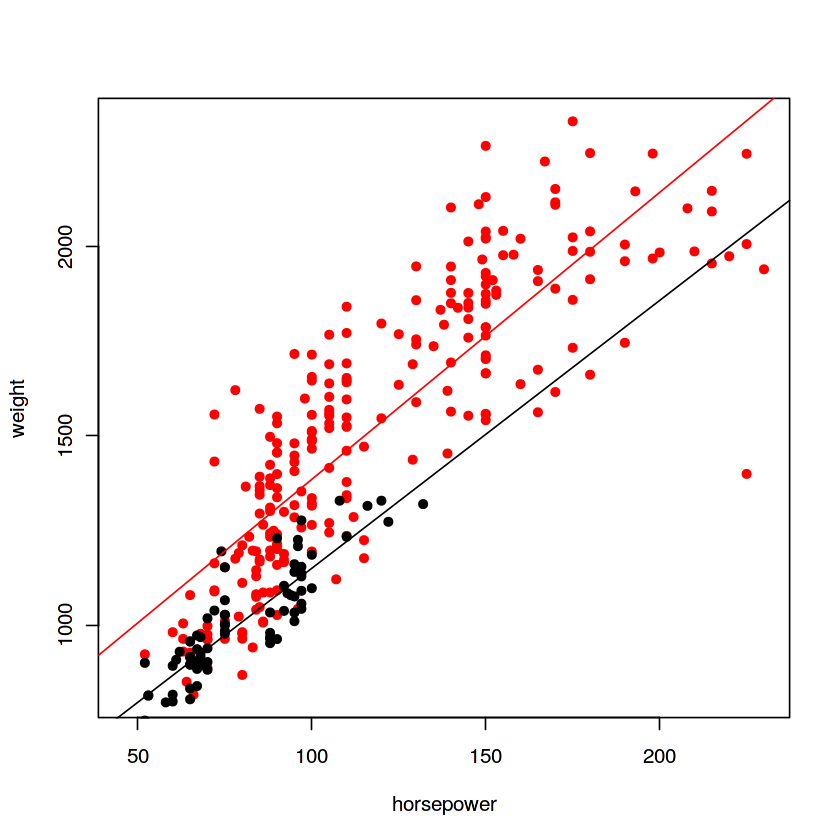

In [8]:
plot(america$horsepower, america$weight, 
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "red",
     xlim = range(Auto$horsepower))
points(europe$horsepower, europe$weight, pch = 16)
# La función `lm` realiza el ajuste de un modelo lineal entre ambas variables:
abline(lm(weight~horsepower, data = america), col = "red")
abline(lm(weight~horsepower, data = europe))

# 3 Definición de las funciones de error

A continuación se definen las funciones que se van a emplear para determinar el error del modelo, y que será el error medio absoluto (*mean absolute error*, $MAE$) y el error cuadrático medio (*root mean square error*, $RMSE$):

In [9]:
# Error Functions:
mae <- function(obs, est) {
  mean(abs(obs - est))
}

rmse <- function(obs, est) {
  sqrt(mean((obs - est)^2))
}

# 4 Construcción del modelo y evaluación

## 4.1 Contrucción del modelo sin validación cruzada

La función `lm` del paquete básico `stats` realiza el ajuste del modelo lineal:

In [10]:
reg <- lm(weight ~ horsepower, data = europe) 
summary(reg)


Call:
lm(formula = weight ~ horsepower, data = europe)

Residuals:
    Min      1Q  Median      3Q     Max 
-199.19  -51.62   -3.39   40.93  228.99 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 442.4491    37.8077   11.70   <2e-16 ***
horsepower    7.0781     0.4623   15.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 72.76 on 77 degrees of freedom
Multiple R-squared:  0.7527,	Adjusted R-squared:  0.7495 
F-statistic: 234.4 on 1 and 77 DF,  p-value: < 2.2e-16


Se extraen los valores ajustados por el modelo ("fitted values") de `reg`, es decir, el resultado de la applicación del modelo ajustado a los propios datos de entrenamiento `yest`, para comparar la estimación (o predicción) del modelo con los datos reales (observados):

In [11]:
yest <- reg$fitted.values

***
**Nota**: Este procedimiento es idéntico (salvando posibles errores de redondeo) a utilizar nuestro modelo para predecir la respuesta (*weight*) en función del predictor (*horsepower*), empleando exactamente el mismo subcontunto que se utilizó en el proceso de entrenamiento:

In [12]:
yest_bis <- predict(object = reg, newdata = data.frame(horsepower = europe$horsepower))


***

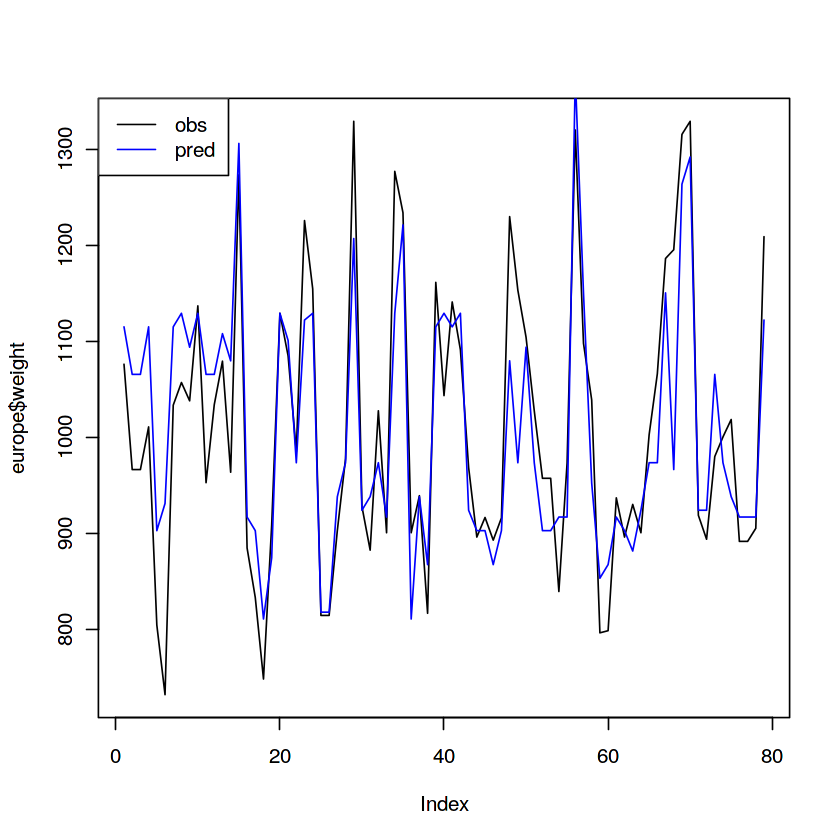

In [13]:
plot(europe$weight, type = 'l')
lines(yest, col = 'blue')
legend("topleft", c("obs","pred"), lty=1, col = c("black", "blue"))

Por último, se calcula el error de la estimación (MAE y RMSE):

In [14]:
mae(obs = europe$weight, yest)
rmse(obs = europe$weight, yest)

[1] 55.00146

[1] 71.83323

Adicionalmente, la correlación proporciona otra medida del error, relacionada con la *asociación* entre las series observada y predicha:

In [15]:
cor(europe$weight, yest, method = "spearman")

[1] 0.8804006

***
El ejercicio anterior utiliza todos los datos para entrenar y validar el modelo. Es decir, la validación se realiza utilizando como conjunto de validación el mismo conjunto utilizado como "train" (conjunto de entrenamiento). Por lo tanto no podemos estimar la capacidad de generalización o sobreajuste del modelo. 

Si la validación se realiza sobre un conjunto independiente de la muestra de entrenamiento el error esperable es mayor. Ilustraremos esto con los siguientes ejemplos:
***

## 4.2 Construcción del modelo y validación *hold-out* 

El modo más básico de analizar el error de mi modelo es dividiendo la muestra en subconjuntos disjuntos (hold out). En este primer caso consideraremos sólo dos conjuntos, uno de train y otro de validación con la mitad de datos (instancias, i.e. filas) en cada uno. 

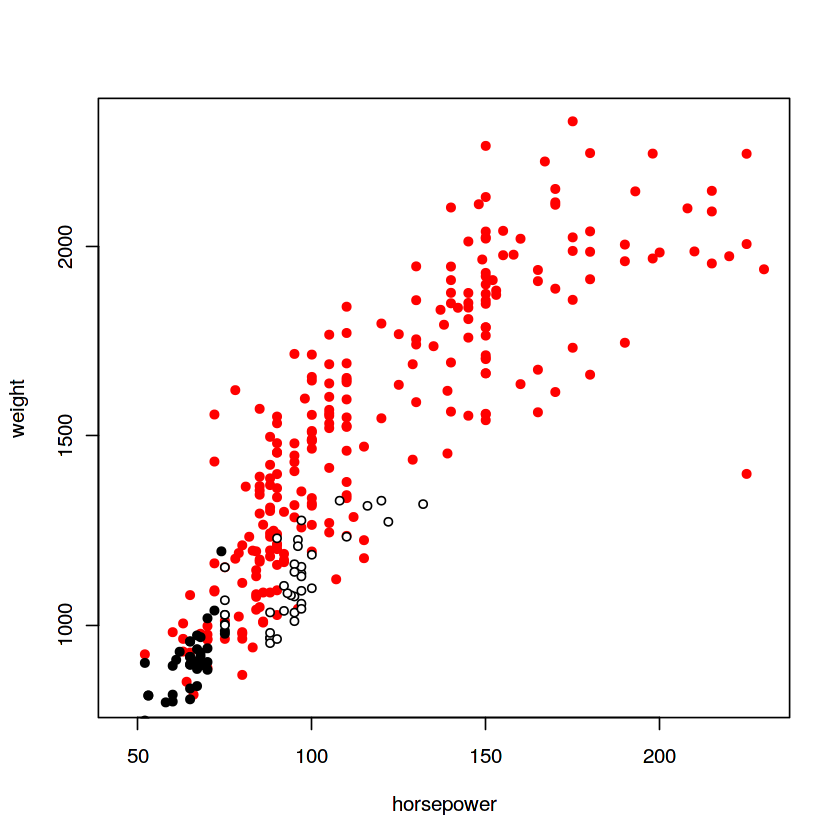

In [16]:
n <- nrow(europe)
ind <- order(europe$horsepower)[1:ceiling(n/2)]
europe.train <- europe[ind, ]
europe.val <- europe[-ind,]

plot(america$horsepower, america$weight, 
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "red",
     xlim = range(Auto$horsepower))
points(europe.train$horsepower, europe.train$weight, pch = 16, col = "black")
points(europe.val$horsepower, europe.val$weight, pch = 21, bg = "white", cex = 0.8)

Aplicamos de nuevo las funciones `lm` (para ajustar el modelo) y  `predict` (para aplicar el modelo sobre los datos de "train" y de "validación") y calculamos el RMSE:

In [17]:
reg0 <- lm(weight~horsepower, data = europe.train)
yest0.train <- predict(reg0, newdata = data.frame(horsepower = europe.train$horsepower))
yest0.val <- predict(reg0, newdata = data.frame(horsepower = europe.val$horsepower))
rmse(europe.train$weight, yest0.train)
rmse(europe.val$weight, yest0.val)

[1] 65.29786

[1] 92.58811

***
Como resulta obvio, Hemos entrenado con los valores de horsepower menores, por lo que **nuestra muestra no es representativa de la población**. 
***

### 4.2.1 Muestreo aleatiorio para obtener las muestras de train y de validación

Para intentar minimizar el sesgo de nuestra muestra de entrenamiento, una solución es aleatorizar la selección. En este ejemplo utilizamos la función `sample` para obtener un índice de registros aleatoria. 

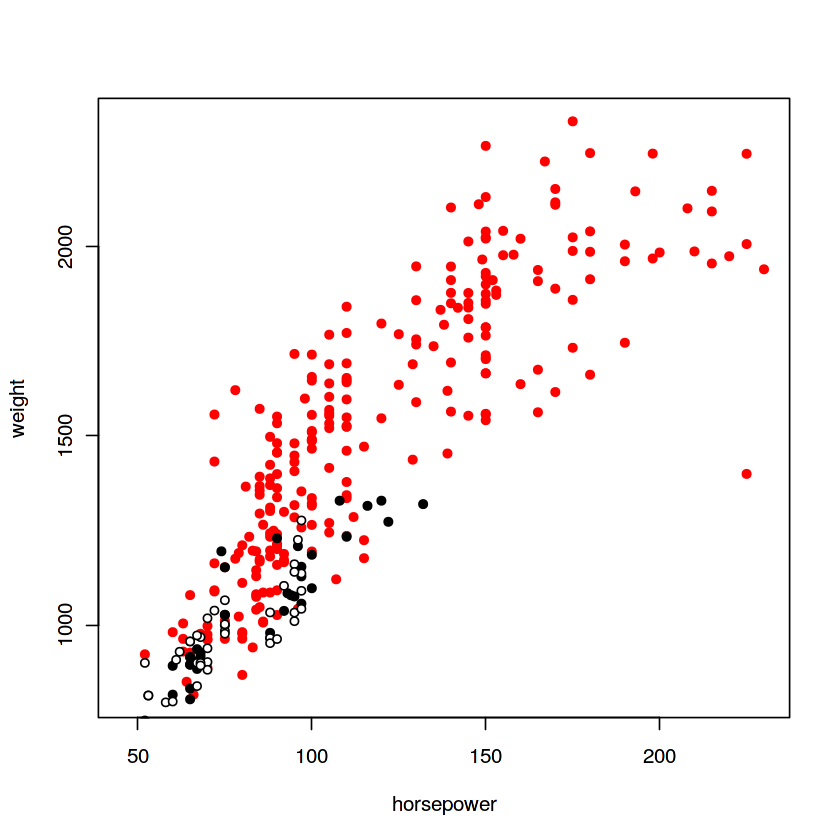

In [18]:
n <- nrow(europe)
set.seed(1)
ind <- sample(1:n, ceiling(n/2))
europe.train <- europe[ind, ]
europe.val <- europe[-ind,]

plot(america$horsepower, america$weight, 
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "red",
     xlim = range(Auto$horsepower))
points(europe.train$horsepower, europe.train$weight, pch = 16, col = "black")
points(europe.val$horsepower, europe.val$weight, pch = 21, bg = "white", cex = 0.8)

Aplicamos de nuevo la funciones `lm` (para ajustar el modelo) y  `predict` (para aplicar el modelo sobre los datos de "train" y de "validación") y calculamos el RMSE:

In [19]:
reg1 <- lm(weight~horsepower, data = europe.train)
yest1.train <- predict(reg1, newdata = data.frame(horsepower = europe.train$horsepower))
yest1.val <- predict(reg1, newdata = data.frame(horsepower = europe.val$horsepower))
rmse(europe.train$weight, yest1.train)
rmse(europe.val$weight, yest1.val)

[1] 68.84407

[1] 75.66424

***
Al considerar una muestra representativa de la variabilidad de la población el error de validación es más bajo y se asemeja más al error de train que en el ejemplo anterior.

**El modelo entrenado con una muestra aleatoria de `europe` tiene más capacidad de generalización** ya que:

Decimos que existe sobreajuste cuando el error de train y el de validación son muy diferentes. Un modelo con capacidad de generalización, no sobreajustado, es aquel para el que ambos errores, en la muestra de entrenamiento y de test, son similares/comparables.

***

A pesar de ello, esta metodología tiene dos inconvenientes potenciales:

 1.- La estimación del error en el conjunto de validación puede variar mucho en función de la partición considerada:

RMSE fold 1= 81.2083458139439
RMSE fold 2= 74.5862909898564
RMSE fold 3= 72.3664933834022
RMSE fold 4= 76.718205006686
RMSE fold 5= 74.5596898843522


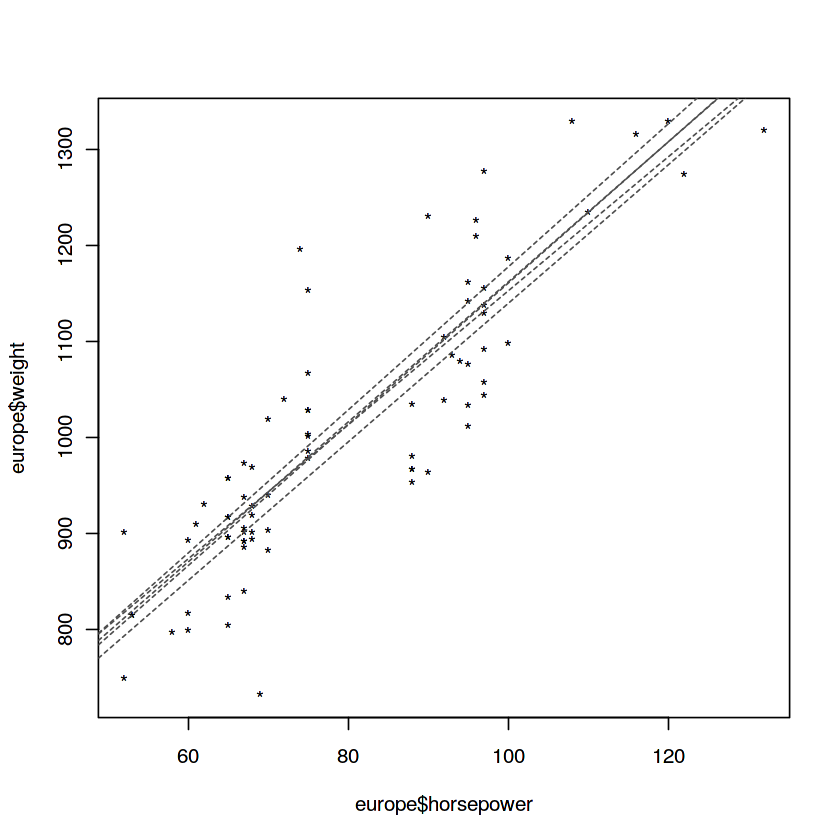

In [20]:
plot(europe$horsepower, europe$weight, pch = "*")
for (i in c(1:5)) {
  ind <- sample(1:n, ceiling(n/2))
  europe.train.i <- europe[ind, ]
  europe.val.i <- europe[-ind, ]
  reg.i <- lm(weight~horsepower, data = europe.train.i)
  yest.val.i <- predict(reg.i, data.frame(horsepower = europe.val.i$horsepower))
  abline(reg.i, lty = 2, col = "grey30")
  message("RMSE fold ", i, "= ",rmse(europe.val.i$weight, yest.val.i))
}

  2.- El error de validación puede ser sobreestimado. Dado que el modelo se entrena en un subconjunto de la muestra y que los métodos estadísticos suelen comportarse peor cuando son entrenados con pocos datos (n/2 = 40 en los ejemplos anteriores), esto puede dar lugar a una sobrestimación del error de validación respecto al obtenido considerando toda la muestra.

La validación cruzada (cross-validación) que aplicaremos un poco más adelante considera estos dos problemas. 

## 4.3 Modelización y cross-validación leave-one-out

Como alternativa al muestreo aleatorio existe el método de validación cruzada denominado leave-one-out:

* La selección de la muestra de entrenamiento NO se hace aleatoriamente, eliminando la variabilidad del error de validación.

* La muestra de entrenamiento es la mayor posible que considera una muestra de validación.

* Si un conjunto de datos tiene `N` registros, el ajuste del modelo se realiza con `N - 1` registros y el registro no considerado en el conjunto de entrenamiento se utiliza como validación o muestra independiente para validar el modelo.

* Esta operación se repite `N` veces, así todos los registros del dataset se utilizan como dato de test para un modelo entrenado con el resto de registros.


In [21]:
ind <- 1:n
yest.2 <- numeric(length = length(ind))

for (i in ind) {
  Reg.i <- lm(weight~horsepower, data = europe, subset = ind[-i])
  yest.2[i] <- predict(Reg.i, data.frame(horsepower = europe$horsepower[i]))
}
rmse(europe$weight, yest.2)

[1] 73.4328

### 4.3.1 Ejemplo anterior con la librería caret

In [22]:
ctrl <- trainControl(method = "LOOCV")
mod <- train(weight ~ horsepower,
               data = europe,
               method = "lm",
               trControl = ctrl)
mod

Linear Regression 

79 samples
 1 predictors

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 78, 78, 78, 78, 78, 78, ... 
Resampling results:

  RMSE     Rsquared  MAE     
  73.4328  0.741626  56.36828

Tuning parameter 'intercept' was held constant at a value of TRUE

In [23]:
mod$results$RMSE

[1] 73.4328

## 4.4 Modelización y cross-validación k-fold

Si el tamaño muestral es grande el método leave-one-out es computacionalmente costoso. Para evitar este coste surge otro método de validación cruzada: **El método k-fold** en el que se hace un leave-one-out por "bloques" o "folds": 

* se divide la muestra en `k` subconjuntos.

* Se ajustan `k` modelos, considerando en cada caso un bloque como conjunto de validación y los `k-1` restantes como muestra de entrenamiento. 

* La estimación dependerá de como se realice la partición de los datos. La variabilidad mayor que en el caso del leave-one-out.

* Con un número suficiente de subconjuntos, se obtienen los mismos resultados y conclusiones que las obtenidas con un leave-one-out. 

Consideramos el ejemplo anterior con 10 subconjuntos y vamos paso a paso.

1) Dividimos la muestra en 10 subconjuntos (`k = 10`)

In [24]:
k <- 10
# Número de registros (instancias u observaciones) en nuestro dataset.
n <- nrow(europe) 
# factor de números aleatorios con k levels (del 1 al 10) 
set.seed(1)
split.factor <- sample(rep(1:10, each = ceiling(n/k)), n) 
# Lista que en cada "slot" contiene un fold 
spl.europe <- split(europe, f = split.factor)
str(spl.europe)

List of 10
 $ 1 :'data.frame':	8 obs. of  9 variables:
  ..$ mpg         : num [1:8] 23 24 32 44.6 33.8 32.7 37 32.4
  ..$ cylinders   : num [1:8] 4 4 4 4 4 6 4 4
  ..$ displacement: num [1:8] 120 119 85 91 97 168 85 108
  ..$ horsepower  : num [1:8] 97 97 70 67 67 132 65 75
  ..$ weight      : num [1:8] 1137 1154 903 839 973 ...
  ..$ acceleration: num [1:8] 14.5 17 17 13.8 18 11.4 19.4 16.8
  ..$ year        : num [1:8] 72 75 76 80 80 80 81 81
  ..$ origin      : chr [1:8] "European" "European" "European" "European" ...
  ..$ name        : Factor w/ 304 levels "amc ambassador brougham",..: 279 88 91 170 262 81 80 266
 $ 2 :'data.frame':	8 obs. of  9 variables:
  ..$ mpg         : num [1:8] 31 27 20 22 32.4 33.7 31.6 34
  ..$ cylinders   : num [1:8] 4 4 4 6 4 4 4 4
  ..$ displacement: num [1:8] 71 97 97 146 107 107 120 108
  ..$ horsepower  : num [1:8] 65 88 88 97 72 75 74 70
  ..$ weight      : num [1:8] 804 953 1034 1277 1039 ...
  ..$ acceleration: num [1:8] 19 16.5 19 14.5 17 14.4

2) ajustamos el modelo con la función `lm` con `k-1` y predecimos (función `predict`) sobre el fold restante. Se repite la operación `k` veces (en un bucle lapply):

List of 10
 $ : Named num [1:8] 1131 1131 937 915 915 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 898 1061 1061 1124 947 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 1118 873 973 923 1132 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 1070 1085 939 809 867 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:7] 917 1119 1217 938 882 ...
  ..- attr(*, "names")= chr [1:7] "1" "2" "3" "4" ...
 $ : Named num [1:8] 1066 1094 1108 1129 1291 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 1130 1309 900 900 1094 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 813 1096 1200 917 972 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 1119 937 910 979 875 ...
  ..- attr(*, "names")= chr [1:8] "1" "2" "3" "4" ...
 $ : Named num [1:8] 1112 818 818 972 1112 ...
  ..- attr(*, "names")= chr [

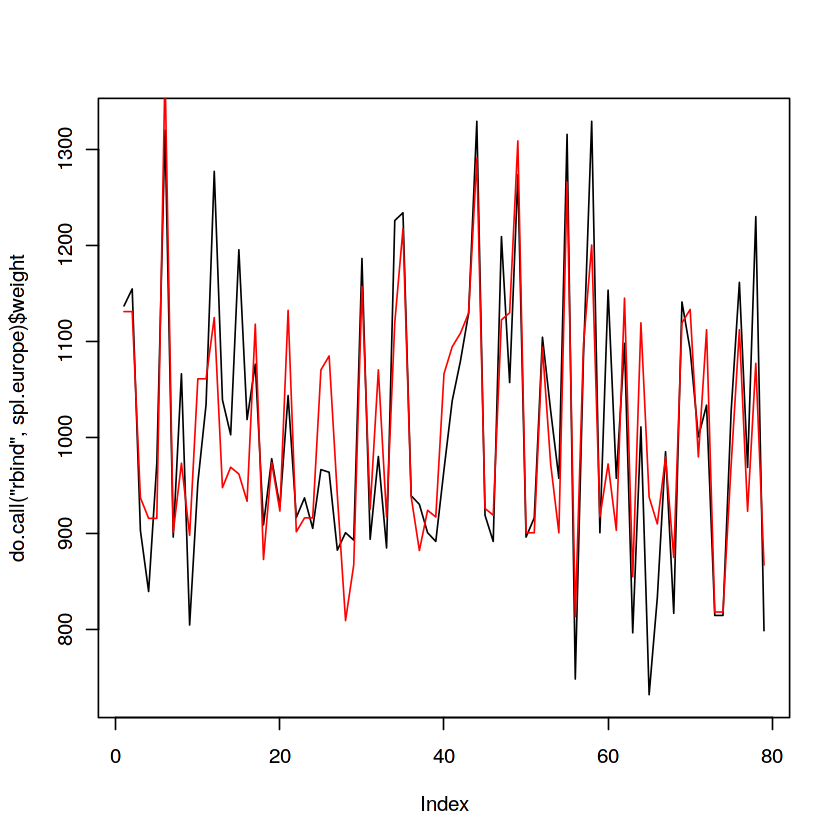

In [25]:
yest.3 <- lapply(1:k, function(x) {
  reg.3 <- lm(weight~horsepower, data = do.call("rbind", spl.europe[-x]))
  predict(reg.3, data.frame(horsepower = spl.europe[[x]]$horsepower))
})
str(yest.3)
# Hacemos un plot de los valores de weight rales frente a los estimados 
plot(do.call("rbind", spl.europe)$weight, typ = "l")
lines(do.call("c", yest.3), col = "red")

3) Calculamos el error

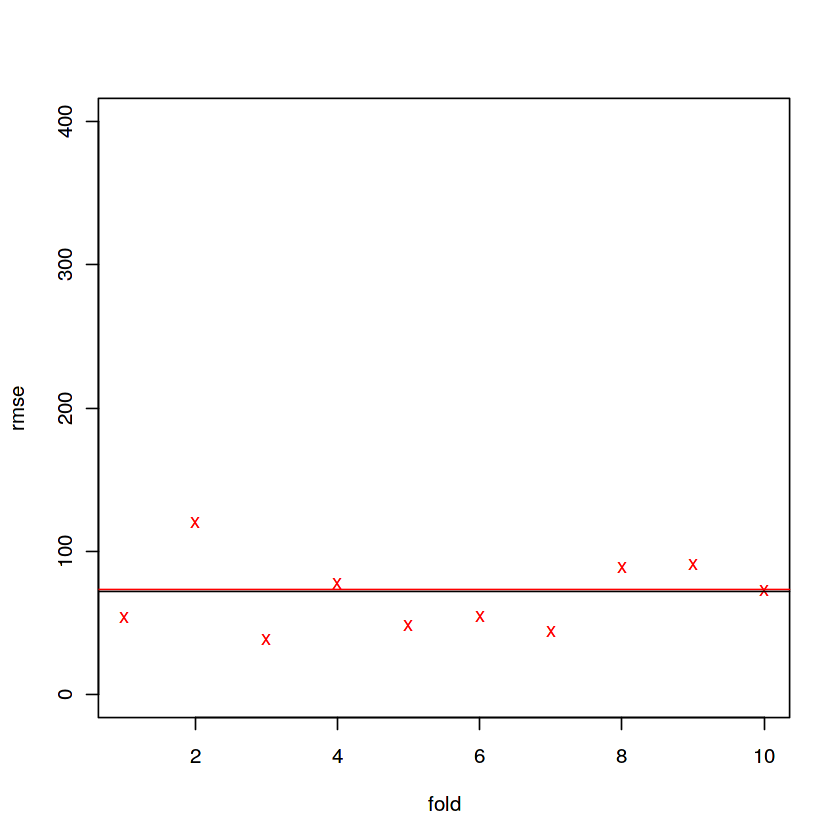

In [26]:
# de cada fold
rmse.val.3.folds <- lapply(1:length(spl.europe), function(x) rmse(spl.europe[[x]]$weight, yest.3[[x]]))
# de la muestra entera
rmse.val.3 <- rmse(do.call("rbind", spl.europe)$weight, do.call("c", yest.3))
plot(do.call("c", rmse.val.3.folds), ylab = "rmse", xlab = "fold", pch = "x", ylim = c(0, 400), col = "red")
abline(h = rmse.val.3, col = "red")
abline(h = rmse(obs = europe$weight, yest))

# Práctica 1

¿Es el modelo aprendido con los registros europeos adecuado para estimar el peso de los coches americanos? (¿qué ocurre cuando aplicamos el modelo a la muestra de test (objeto `america`)?)

Utiliza las funciones de visualización (`plot`, `points`, `lines`, `abline`, ...) para ilustrar los resultados.

Escribe el código a continuación:

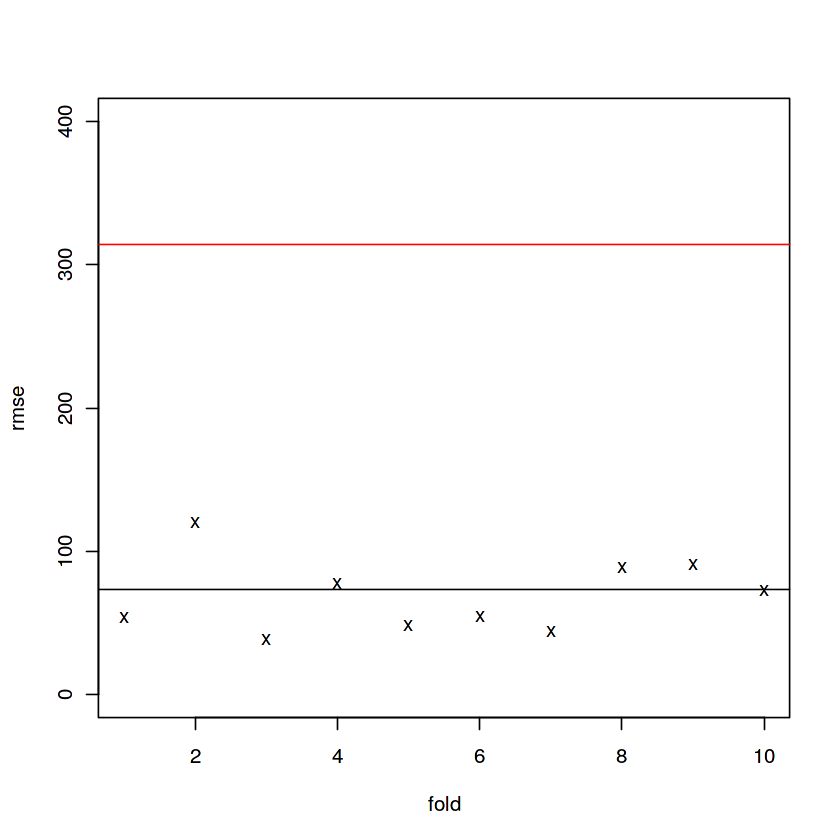

In [27]:
reg.3.all <- lm(weight~horsepower, data = europe)
yest.test.3 <- predict(reg.3.all, newdata = data.frame(horsepower = america$horsepower))
plot(do.call("c", rmse.val.3.folds), ylab = "rmse", xlab = "fold", pch = "x", ylim = c(0, 400))# error de validación obtenido anteriormente para cada fold
abline(h = rmse.val.3)# error de validación global (de todos los folds) obtenido anteriormente 
abline(h = rmse(america$weight, yest.test.3), col = "red") # error de test

El error que obteníamos en modo cross-validación (RMSE) es muy similar al obtenido sin cross-validación, y por lo tanto, podemos decir que la capacidad de generalización del modelo es buena para los coches de europa, es decir, para predecir el peso de coches europeos a partir de datos de potencia de motor. Sin embargo, este modelo no nos sirve para predecir el peso de los coches americanos, ya que la diferencia del error de validación y el error de test (horizontal roja) es muy alta. 

Veámos la correlación entre los valores reales y los estimados:


In [28]:
cor(america$weight, yest.test.3)

[1] 0.83845

Sin embrango, la correlación es solo algo menor que en el ejemplo que veíamos anteriormente.

Veámos el gráfico de los valores reales y los valores estimados para entender mejor lo que ocurre:

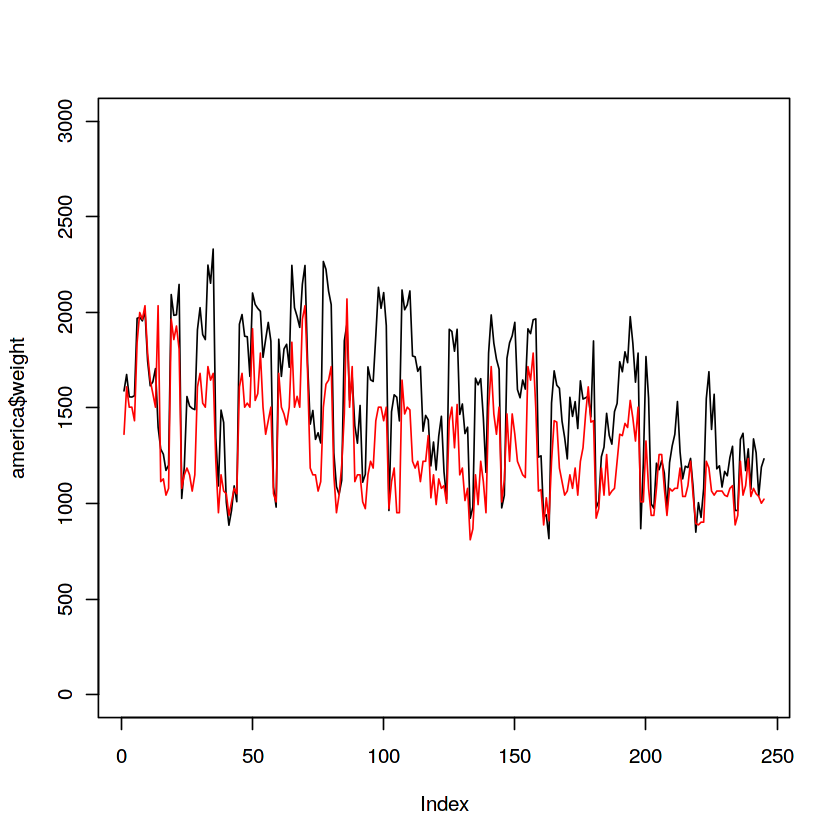

In [29]:
plot(america$weight, type = "l", ylim = c(0, 3000))
lines(yest.test.3, col = "red")

La forma de la líneas son similares, por eso obtenemos una correlación cercana a 1, sin embargo, como es lógico, el modelo subestima los pesos de los coches americanos, de ahí que el error de test (RMSE) sea tan diferente en comparación al error de validación.

# Práctica 2

Utiliza la librería caret para reproducir el último ejemplo de cross-validación con k-fold y obtén el error de validación global.

Escribe el código a continuación:

In [30]:
ctrl <- trainControl(method = "cv", number = 10)
mod <- train(weight ~ horsepower,
               data = europe,
               method = "lm",
               trControl = ctrl,
               metric = "RMSE")

# Práctica 3

Utiliza los datos de los coches americanos para estimar los pesos de los coches europeos por un lado y la de los japoneses por otro.

¿Es el modelo aprendido adecuado para estimar el peso de los coches europeos y japoneses?

Utiliza caret y las funciones de visualización (`plot`, `points`, `lines`, `abline`, ...) para ilustrar los resultados. 

Escribe el código a continuación:

Linear Regression 

245 samples
  1 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 219, 220, 221, 221, 221, 221, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  194.4469  0.7343611  162.0253

Tuning parameter 'intercept' was held constant at a value of TRUE

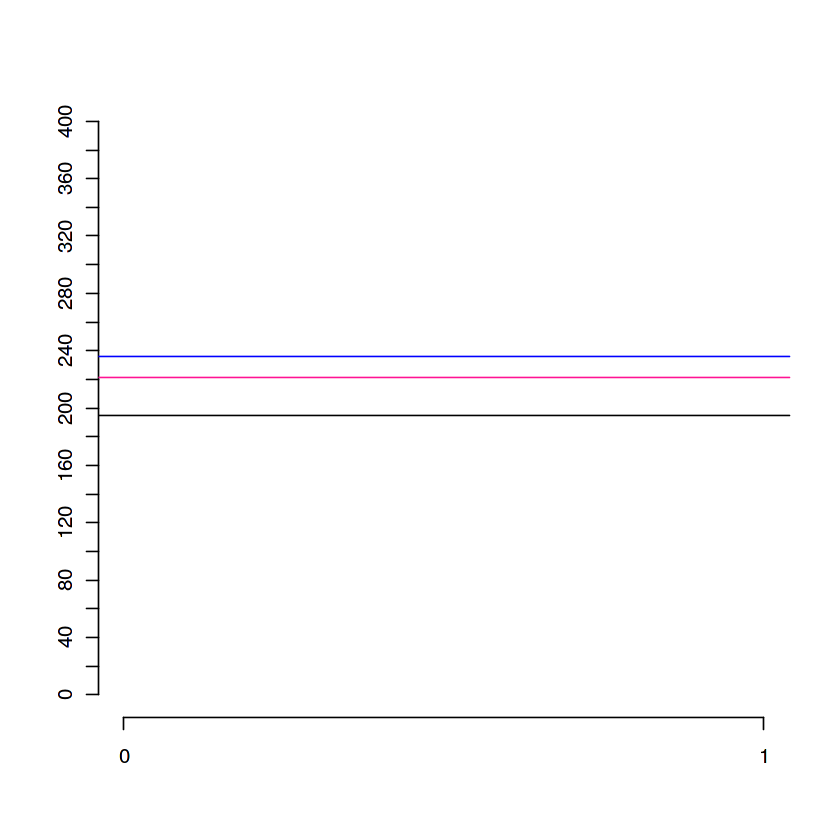

In [31]:
japan <- Auto[Auto$origin == "Japanese", ]

ctrl <- trainControl(method = "cv", number = 10)
mod <- train(weight ~ horsepower,
               data = america,
               method = "lm",
               trControl = ctrl,
               metric = "RMSE")
mod
yest.japan <- predict(mod, data.frame(horsepower = japan$horsepower))
yest.europe <- predict(mod, data.frame(horsepower = europe$horsepower))
rmse.japan <- rmse(japan$weight, yest.japan)
rmse.europe <- rmse(europe$weight, yest.europe)

plot.new()
plot.window(xlim = c(0,1), ylim = c(0, 400))
axis(1, at = seq(0, 1, 1))
axis(2, at = seq(0, 400, 20))
abline(h = mod$results$RMSE)
abline(h = rmse.japan, col = "deeppink")
abline(h = rmse.europe, col = "blue")


En este caso, el valor del error de la validación (horizontal negra) es mayor que cuando entrenábamos nuestro modelo con los coches europeos (los primeros ejemplos de este notebook), esto es debido a que, en este caso (entrenando con los datos americanos) estamos trabajando con valores de peso más altos, por lo tanto, es lógico que el RMSE sea también más alto. Sin embargo, cuando comparamos este error con los errores de test (coches europeos y coches japoneses) se parecen más que en el caso anterior, los tres errores están entre 195 y 236. Esto se debe a que el rango de potencia del motor para los coches americanos es mucho mayor y el rango de coches europeos y japoneses se encuentran en parte incluidos o representados por los coches americanos. 

Por lo tanto, basándonos en el RMSE, un modelo entrenado con los coches americanos en lugar de con los coches europeos parece mejor  para estimar el peso de los coches de otros orígenes. 


Veámos la correlación y el gráfico de los valores reales vs estimados para europa:

[1] 0.8675895

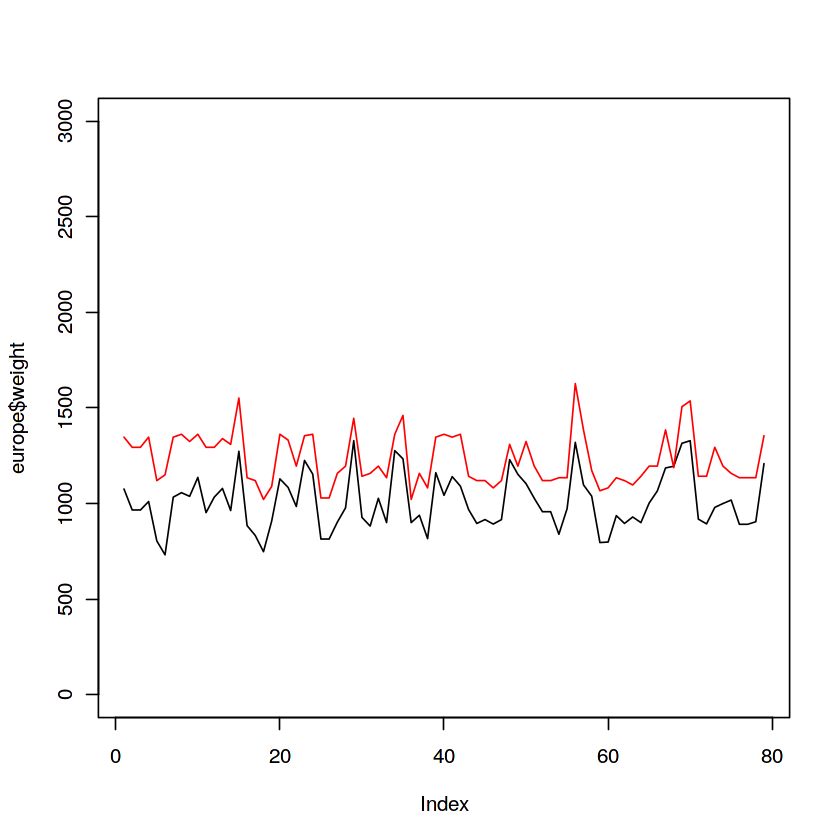

In [32]:
cor(europe$weight, yest.europe)

plot(europe$weight, type = "l", ylim = c(0, 3000))
lines(yest.europe, col = "red")

En este caso la correlación es mayor, pero sobreestima el peso de los coches europeos.

**Por lo tanto, construiríamos un modelo mejor (sin sobrajuste y con capacidad de generalización) con una muestra de entrenamiento más representativa de la población total, aquella que incluyese datos de coches de diferentes orígenes.**
